In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

from tensorflow.keras.regularizers import l2
from ot2_env_wrapper_updated_2 import OT2Env
from sim_class import Simulation

In [2]:
from stable_baselines3 import PPO
import numpy as np

# Initialise the simulation environment
# Initialize the environment
env = OT2Env(render=True, max_steps=200)

# Reset the environment
obs, info = env.reset()

# Get the plate image (assumes the Simulation class has a get_plate_image method implemented)
plate_image = env.get_plate_image()

# Do something with the plate image
print("Plate image:", plate_image)

Successfully loaded:
  Main texture:  textures\06.png
  Plate texture: textures/_plates\035_43-17-ROOT1-2023-08-08_mock_pH5_+Fe_Col0_04-Fish Eye Corrected.png
Plate image: textures/_plates\035_43-17-ROOT1-2023-08-08_mock_pH5_+Fe_Col0_04-Fish Eye Corrected.png


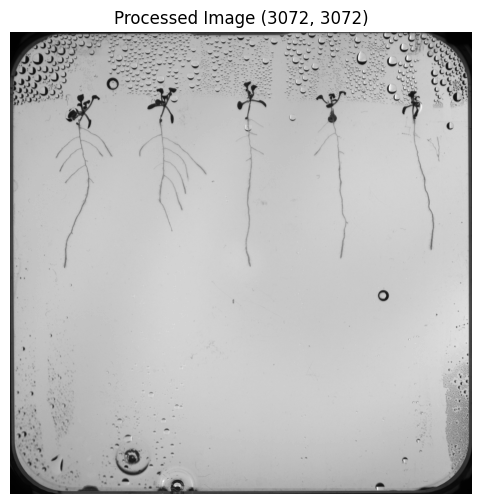

In [3]:
def process_image(input_path, output_path):
    # Load the image
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

    # Threshold the image to isolate the object of interest
    _, thresh = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get bounding box of the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image to the bounding box
    cropped_img = img[y:y+h, x:x+w]

    # Resize to a square format
    final_size = 3072
    resized_img = cv2.resize(cropped_img, (final_size, final_size))

    # Save the processed image
    cv2.imwrite(output_path, resized_img)

    return resized_img

def process_and_display_image(input_image_path, output_image_path):
    # Process the input image
    processed_img = process_image(input_image_path, output_image_path)

    # Display the processed image
    plt.figure(figsize=(6, 6))
    plt.imshow(processed_img, cmap='gray')
    plt.title(f"Processed Image ({processed_img.shape[1]}, {processed_img.shape[0]})")
    plt.axis('off')
    plt.show()

    return processed_img

# Example usage
input_image_path = plate_image # Replace with the path to your input image
output_image_path = "path_to_save_processed_image.png"  # Replace with the desired output path

processed_img = process_and_display_image(input_image_path, output_image_path)


In [4]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

# Define Combined Loss Function
def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return 0.5 * bce + 0.5 * dice

from tensorflow.keras.models import load_model
patch_size = 256
example_file_name = "stijn_232027_unet_model8_256px.h5"
model = load_model(example_file_name, custom_objects={"f1": f1, "dice_loss": dice_loss, "combined_loss": combined_loss})

5/5 [==============================] - 3s 517ms/step


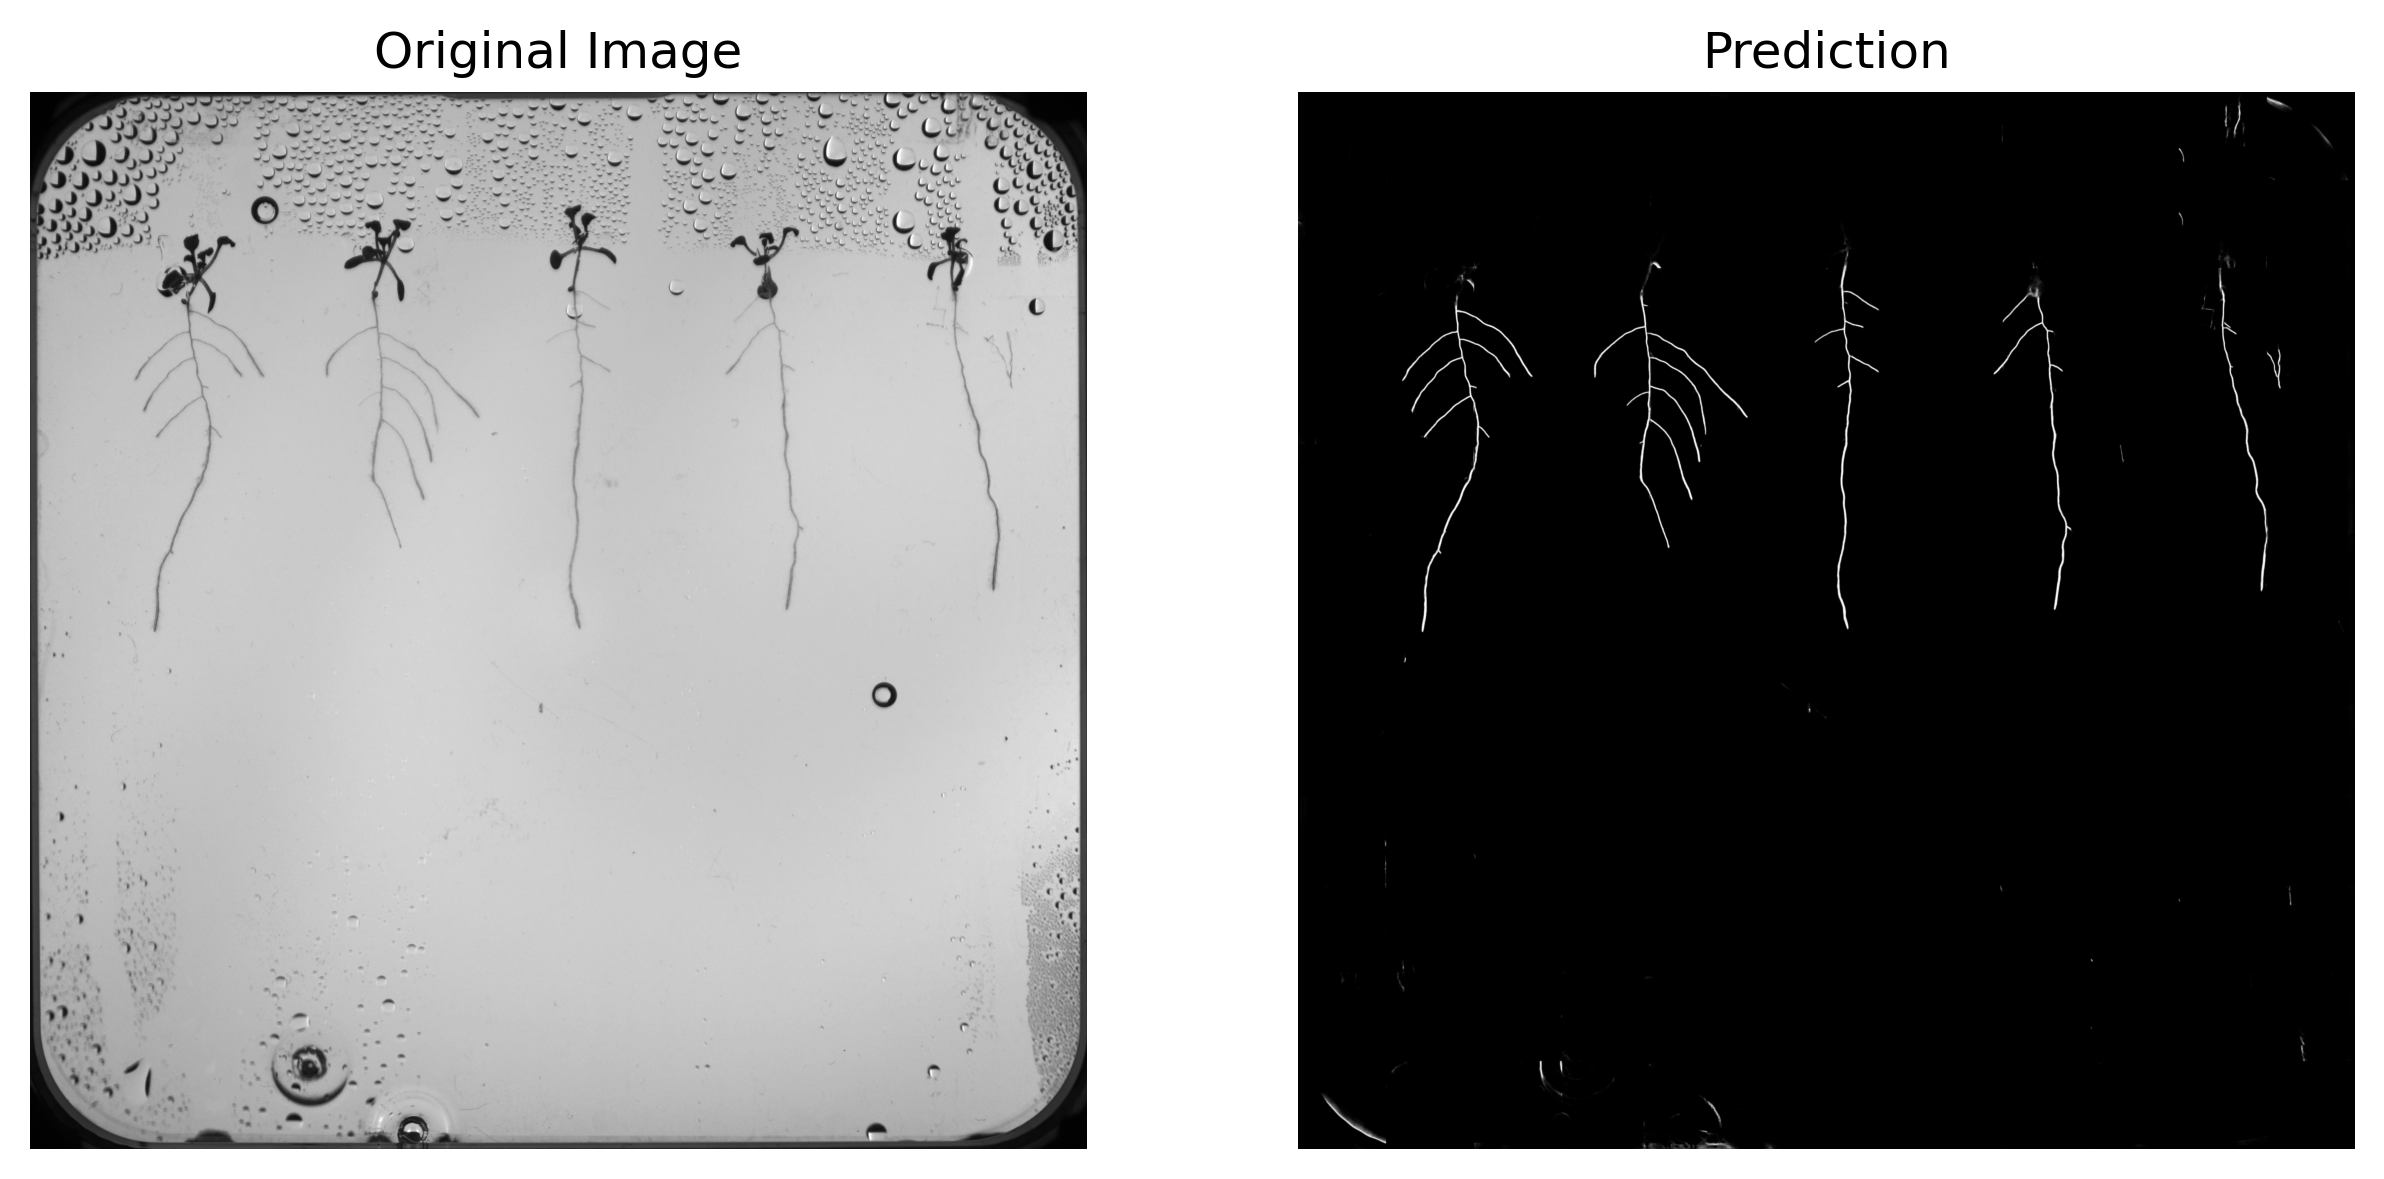

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# PATCH
def make_patches(image, patch_size):
    h, w = image.shape[:2]
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size]
            # Pad patch if it goes out of bounds
            if patch.shape[:2] != (patch_size, patch_size):
                pad_h = patch_size - patch.shape[0]
                pad_w = patch_size - patch.shape[1]
                patch = np.pad(patch, ((0, pad_h), (0, pad_w)), mode='constant')
            patches.append(patch)
    return patches

# PREDICT
def predict_patches(patches, model, patch_size):
    patches = np.array(patches).astype('float32') / 255.0  # Normalize
    patches = patches.reshape(-1, patch_size, patch_size, 1)
    predictions = model.predict(patches, verbose=1)
    return predictions

# UNPATCH
def unpatch(patches, predictions, image_shape):
    h, w = image_shape[:2]
    patch_size = patches[0].shape[0]
    reconstructed = np.zeros((h, w))
    patch_index = 0
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch_prediction = predictions[patch_index].reshape((patch_size, patch_size))
            # Crop to fit original image dimensions
            reconstructed[i:i+patch_size, j:j+patch_size] = patch_prediction[:h-i, :w-j]
            patch_index += 1
    return reconstructed

# Usage for a Single Image
def process_single_image(image, model, patch_size):
    # Process image
    patches = make_patches(image, patch_size)
    predicted_patches = predict_patches(patches, model, patch_size)
    predicted_mask = unpatch(patches, predicted_patches, image.shape)

    # Visualization
    _, ax = plt.subplots(1, 2, dpi=300, figsize=(10, 5))
    ax[0].imshow(image, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('Original Image')
    ax[1].imshow(predicted_mask, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Prediction')
    plt.show()

    # Save the prediction (if needed)
    cv2.imwrite("predicted_mask.png", (predicted_mask * 255).astype(np.uint8))

    return predicted_mask

# Example Usage
patch_size = 256
predicted_mask = process_single_image(processed_img, model, patch_size)


In [6]:
import numpy as np

def divide_into_sections(predicted_mask):
    """
    Divide a mask (NumPy array) into 5 vertical sections.

    Parameters:
    - predicted_mask: A NumPy array representing the predicted mask.

    Returns:
    - sections: A list of NumPy arrays, each representing a vertical section.
    """
    # Get the dimensions of the mask
    height, width = predicted_mask.shape
    section_width = width // 5  # Divide into 5 equal sections

    # Divide the mask into 5 sections
    sections = []
    for i in range(5):
        start_col = i * section_width
        end_col = (i + 1) * section_width if i < 4 else width  # Last section covers the remaining width
        section = predicted_mask[:, start_col:end_col]
        sections.append(section)

    # Create a folder to save the sections if it doesn't exist
    output_folder = 'C:\\Users\\stijn\\OneDrive\\Documenten\\GitHub\\Robotics_Learning\\textures\\_mask_predicted_sections'
    os.makedirs(output_folder, exist_ok=True)

    # Save each section as an image
    for idx, section in enumerate(sections):
        section_path = os.path.join(output_folder, f"section_{idx + 1}.png")
        cv2.imwrite(section_path, section)

    return sections

# Divide the mask into sections
sections = divide_into_sections(predicted_mask)

# Assign sections to individual variables
section_1, section_2, section_3, section_4, section_5 = sections

# Example: Print the shape of each section
print("Section 1 shape:", section_1.shape)
print("Section 2 shape:", section_2.shape)
print("Section 3 shape:", section_3.shape)
print("Section 4 shape:", section_4.shape)
print("Section 5 shape:", section_5.shape)


Section 1 shape: (3072, 614)
Section 2 shape: (3072, 614)
Section 3 shape: (3072, 614)
Section 4 shape: (3072, 614)
Section 5 shape: (3072, 616)


Processing sections for Test_Image


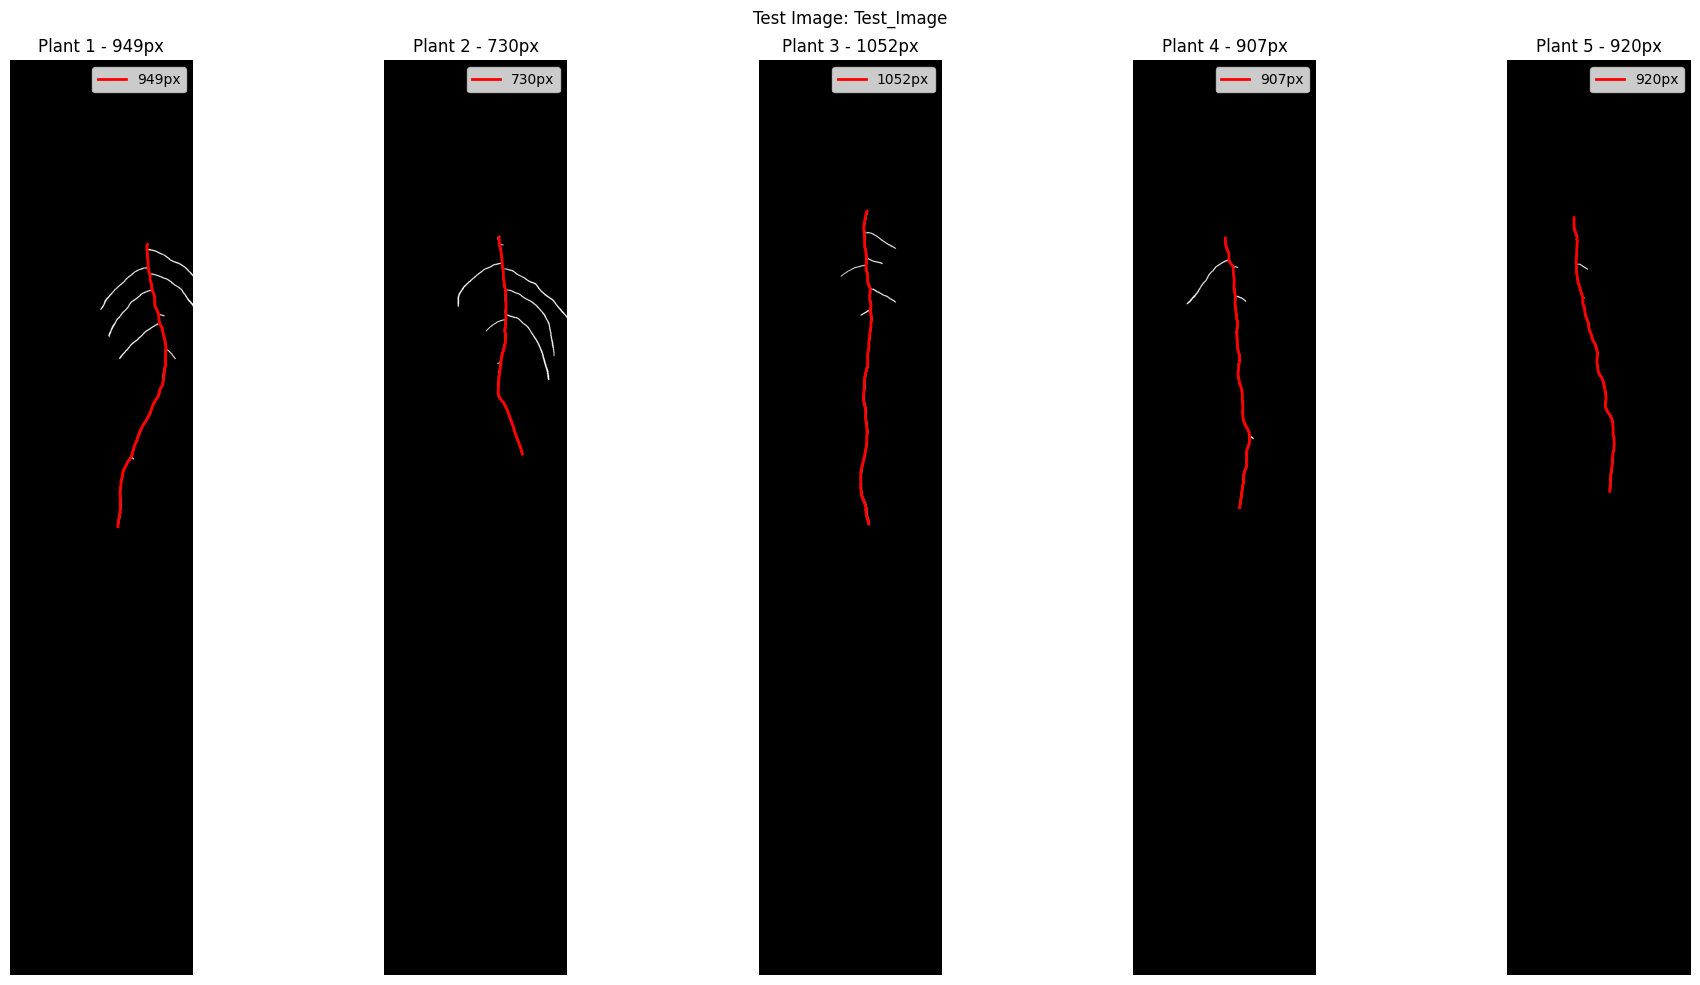

Root Endpoints: {'Test_Image_plant_1': (1566, 362), 'Test_Image_plant_2': (1322, 463), 'Test_Image_plant_3': (1557, 369), 'Test_Image_plant_4': (1502, 357), 'Test_Image_plant_5': (1447, 344)}


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import distance_transform_edt
from skimage.measure import label, regionprops
from skimage.graph import route_through_array
from skimage.morphology import skeletonize
from skimage.transform import resize

# Specify the folder containing the image sections
folder_path = r"C:\Users\stijn\OneDrive\Documenten\GitHub\Robotics_Learning\textures\_mask_predicted_sections"

def process_section(image):
    # Normalize the image
    normalized_image = image / 255.0
    normalized_image = np.clip(normalized_image, 0, 1)

    # Segment plants in the section
    plant_masks = segment_plants_with_root_following(normalized_image)

    # Return all plant masks
    return plant_masks

def segment_plants_with_root_following(image):
    """
    Segment plants by starting from top regions and following roots downward.
    """
    top_region = image[:800, :]
    labeled_top = label(top_region > 0, connectivity=2)
    regions = regionprops(labeled_top)

    plant_masks = []
    for region in regions:
        mask = (labeled_top == region.label).astype(np.uint8)
        full_mask = propagate_downward(mask, image)
        plant_masks.append(full_mask)

    return plant_masks

def propagate_downward(mask, image):
    full_mask = np.zeros_like(image, dtype=np.uint8)
    full_mask[:mask.shape[0], :] = mask
    
    labeled, num_labels = label(image > 0, connectivity=2, return_num=True)
    for label_id in range(1, num_labels + 1):
        region = (labeled == label_id).astype(np.uint8)
        if np.any(np.logical_and(region, full_mask)):
            full_mask = np.logical_or(full_mask, region)

    return full_mask.astype(np.uint8)

def filter_largest_plants(plant_masks, num_plants=1):
    plant_sizes = [np.sum(mask) for mask in plant_masks]
    largest_indices = np.argsort(plant_sizes)[-num_plants:]
    return [plant_masks[i] for i in largest_indices]

def calculate_primary_root_length_thickest_path(mask):
    skeleton = skeletonize(mask > 0)
    if not np.any(skeleton):
        return 0, None, None

    distance_map = distance_transform_edt(mask)
    cost_map = np.max(distance_map) - distance_map

    rows, cols = np.where(skeleton > 0)
    top_row = rows.min()
    start_col = cols[rows == top_row][len(cols[rows == top_row]) // 2]
    start = (top_row, start_col)

    bottom_row = rows.max()
    end_col = cols[rows == bottom_row][len(cols[rows == bottom_row]) // 2]
    end = (bottom_row, end_col)

    path, cost = route_through_array(cost_map, start, end, fully_connected=True)
    path_coords = np.array(path)
    return len(path_coords), path_coords, end

def resize_mask(mask, target_shape):
    """
    Resize a mask to the target shape.
    """
    return resize(mask, target_shape, order=0, preserve_range=True).astype(np.uint8)

def get_root_endpoints(final_results):
    """
    Extracts root endpoints for all plants from the final results.
    """
    root_endpoints = {}
    for result in final_results:
        plant_id = result["Plant ID"]
        root_endpoint = result.get("Root Endpoint", None)
        root_endpoints[plant_id] = root_endpoint
    return root_endpoints

# Group sections by test image
section_groups = {}
for filename in os.listdir(folder_path):
    if filename.endswith('.png'):
        # Extract the numeric part after 'section_'
        section_number = int(filename.split('section_')[1].split('.png')[0])
        test_image_name = "Test_Image"  # Since there are no specific test image names, we use a placeholder
        if test_image_name not in section_groups:
            section_groups[test_image_name] = []
        section_groups[test_image_name].append((section_number, os.path.join(folder_path, filename)))

# Sort test images and section paths numerically
for test_image_name, section_data in section_groups.items():
    section_groups[test_image_name] = [path for _, path in sorted(section_data, key=lambda x: x[0])]

# Initialize final results
final_results = []

# Process each test image group
for test_image_name, section_paths in section_groups.items():
    print(f"Processing sections for {test_image_name}")

    plants_for_test_image = [None] * 5  # Initialize list with 5 placeholders for plants

    # Process each section independently
    for idx, section_path in enumerate(section_paths):
        section_image = cv2.imread(section_path, cv2.IMREAD_GRAYSCALE)
        plant_masks = process_section(section_image)

        # Filter the largest plant in the current section
        largest_plants = filter_largest_plants(plant_masks, num_plants=1)
        if largest_plants:
            plants_for_test_image[idx] = largest_plants[0]  # Align with section index

    # Replace None entries with empty masks and calculate root lengths
    for i in range(len(plants_for_test_image)):
        if plants_for_test_image[i] is None:
            plants_for_test_image[i] = np.zeros_like(section_image, dtype=np.uint8)

        root_length, path_coords, root_endpoint = calculate_primary_root_length_thickest_path(plants_for_test_image[i])
        plant_id = f"{test_image_name}_plant_{i + 1}"
        final_results.append({"Plant ID": plant_id, "Length (px)": root_length, "Path Coordinates": path_coords, "Root Endpoint": root_endpoint})

    # Adjust the axes if fewer than 5 plants exist
    fig, axes = plt.subplots(1, len(plants_for_test_image), figsize=(20, 10))
    if len(plants_for_test_image) == 1:
        axes = [axes]

    # Visualize the 5 plants and their root lengths for the test image
    for i, plant_mask in enumerate(plants_for_test_image):
        root_length, path_coords, root_endpoint = calculate_primary_root_length_thickest_path(plant_mask)
        axes[i].imshow(plant_mask, cmap='gray')
        if path_coords is not None:
            axes[i].plot(path_coords[:, 1], path_coords[:, 0], 'r-', linewidth=2, label=f"{root_length}px")
        axes[i].axis('off')
        axes[i].set_title(f'Plant {i + 1} - {root_length}px')
        axes[i].legend()
    plt.suptitle(f'Test Image: {test_image_name}')
    plt.tight_layout()
    plt.show()

# Get root endpoints for all plants
root_endpoints = get_root_endpoints(final_results)
print("Root Endpoints:", root_endpoints)


In [8]:
print(root_endpoints)
# Adjust the second number in each root endpoint by adding 614 only for the second test image plant
adjusted_root_endpoints = {plant: (x, y + 614) if plant == 'Test_Image_plant_2' else (x, y) for plant, (x, y) in root_endpoints.items()}
adjusted_root_endpoints = {plant: (x, y + 614 * 2 ) if plant == 'Test_Image_plant_3' else (x, y) for plant, (x, y) in adjusted_root_endpoints.items()}
adjusted_root_endpoints = {plant: (x, y + 614 * 3 ) if plant == 'Test_Image_plant_4' else (x, y) for plant, (x, y) in adjusted_root_endpoints.items()}
adjusted_root_endpoints = {plant: (x, y + 614 * 4 ) if plant == 'Test_Image_plant_5' else (x, y) for plant, (x, y) in adjusted_root_endpoints.items()}

print(adjusted_root_endpoints)

{'Test_Image_plant_1': (1566, 362), 'Test_Image_plant_2': (1322, 463), 'Test_Image_plant_3': (1557, 369), 'Test_Image_plant_4': (1502, 357), 'Test_Image_plant_5': (1447, 344)}
{'Test_Image_plant_1': (1566, 362), 'Test_Image_plant_2': (1322, 1077), 'Test_Image_plant_3': (1557, 1597), 'Test_Image_plant_4': (1502, 2199), 'Test_Image_plant_5': (1447, 2800)}


In [9]:
import cv2
import numpy as np

# Load the image
image_path = "C:\\Users\\stijn\\OneDrive\\Documenten\\GitHub\\2024-25b-fai2-adsai-StijnvanderPas232027\\dataset_original\\train_images\\train\\train_Alican_230858_im1.png"
image = cv2.imread(image_path)

# Get the dimensions of the image
plate_size_pixels = image.shape[1]  # Assuming the plate size is the width of the image
plate_size_mm = 150  
conversion_factor = plate_size_mm / plate_size_pixels

# Plate position in robot's coordinate space
plate_position_robot = np.array([0.10775, 0.062, 0.127])  # Subtract 0.026 from y-coordinate

# Convert pixel coordinates to mm-space and then to robot-space
root_points_robot = {}

for plant, (x_pixel, y_pixel) in adjusted_root_endpoints.items():
    # Convert pixel coordinates to mm
    x_mm = x_pixel * conversion_factor / 1000
    y_mm = y_pixel * conversion_factor / 1000
    # Convert mm coordinates to robot-space
    root_tip_mm = np.array([x_mm, y_mm, 0])  # Z-axis remains 0 for root tip
    root_tip_robot = root_tip_mm + plate_position_robot

    # Store the result
    root_points_robot[plant] = root_tip_robot

# Add a custom XYZ coordinate after the main processing
custom_xyz = np.array([0, 0, 0.1204589])  # Example custom XYZ coordinate
root_points_robot["End_Location"] = custom_xyz

# Print the converted robot-space coordinates
for plant, coordinates in root_points_robot.items():
    print(f"{plant}: {coordinates}")

Test_Image_plant_1: [0.18421484 0.07967578 0.127     ]
Test_Image_plant_2: [0.17230078 0.11458789 0.127     ]
Test_Image_plant_3: [0.18377539 0.13997852 0.127     ]
Test_Image_plant_4: [0.18108984 0.16937305 0.127     ]
Test_Image_plant_5: [0.1784043  0.19871875 0.127     ]
End_Location: [0.        0.        0.1204589]



Processing Test_Image_plant_1 with goal coordinates: (X=0.18421484375, Y=0.07967578125, Z=0.127)
Step 1:
    Action taken: [-1. -1.  1.]
    Robot position: (X=0.0725, Y=0.0889, Z=0.1205)
    Reward: -0.1122
    Current distance to goal: 0.1122
Step 2:
    Action taken: [ 1.         -0.03861696  0.05961381]
    Robot position: (X=0.0725, Y=0.0888, Z=0.1207)
    Reward: -0.1122
    Current distance to goal: 0.1122
Step 3:
    Action taken: [ 1.         -0.03558806  0.05406119]
    Robot position: (X=0.0730, Y=0.0886, Z=0.1209)
    Reward: -0.1117
    Current distance to goal: 0.1117
Step 4:
    Action taken: [ 1.         -0.03352506  0.0495011 ]
    Robot position: (X=0.0739, Y=0.0885, Z=0.1211)
    Reward: -0.1108
    Current distance to goal: 0.1108
Step 5:
    Action taken: [ 1.         -0.03232857  0.04581269]
    Robot position: (X=0.0753, Y=0.0884, Z=0.1213)
    Reward: -0.1094
    Current distance to goal: 0.1094
Step 6:
    Action taken: [ 1.         -0.03192029  0.04291254]
  

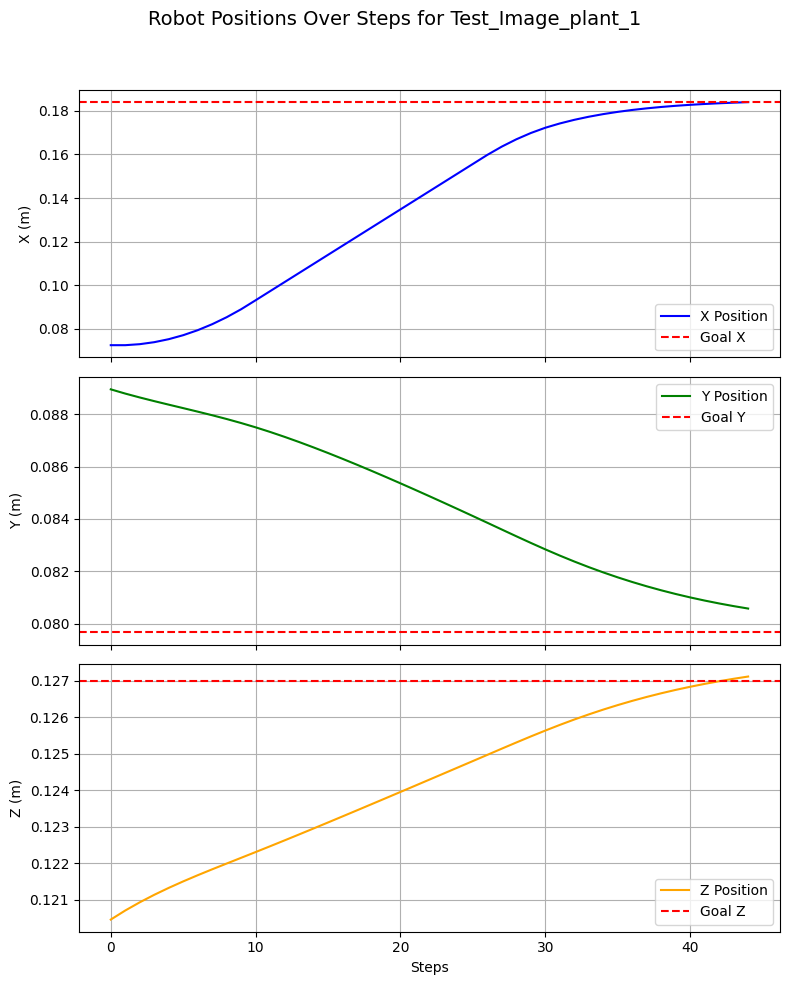

Final accuracy for Test_Image_plant_1: X=0.0002m, Y=0.0009m, Z=0.0001m


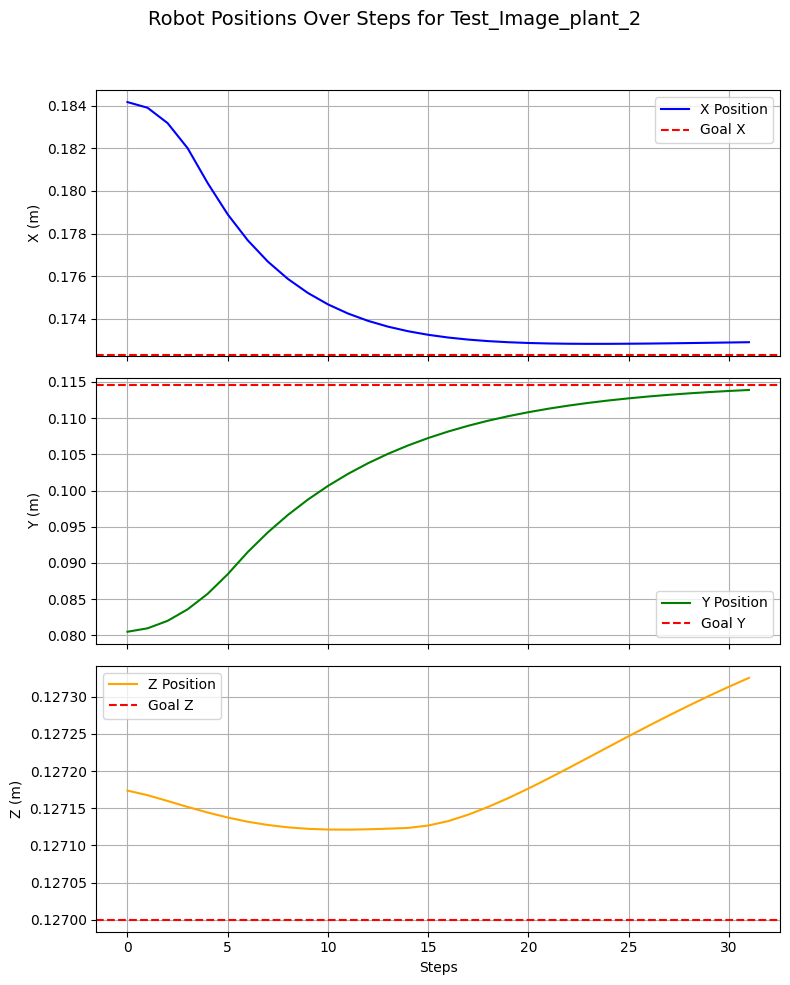

Final accuracy for Test_Image_plant_2: X=0.0006m, Y=0.0007m, Z=0.0003m


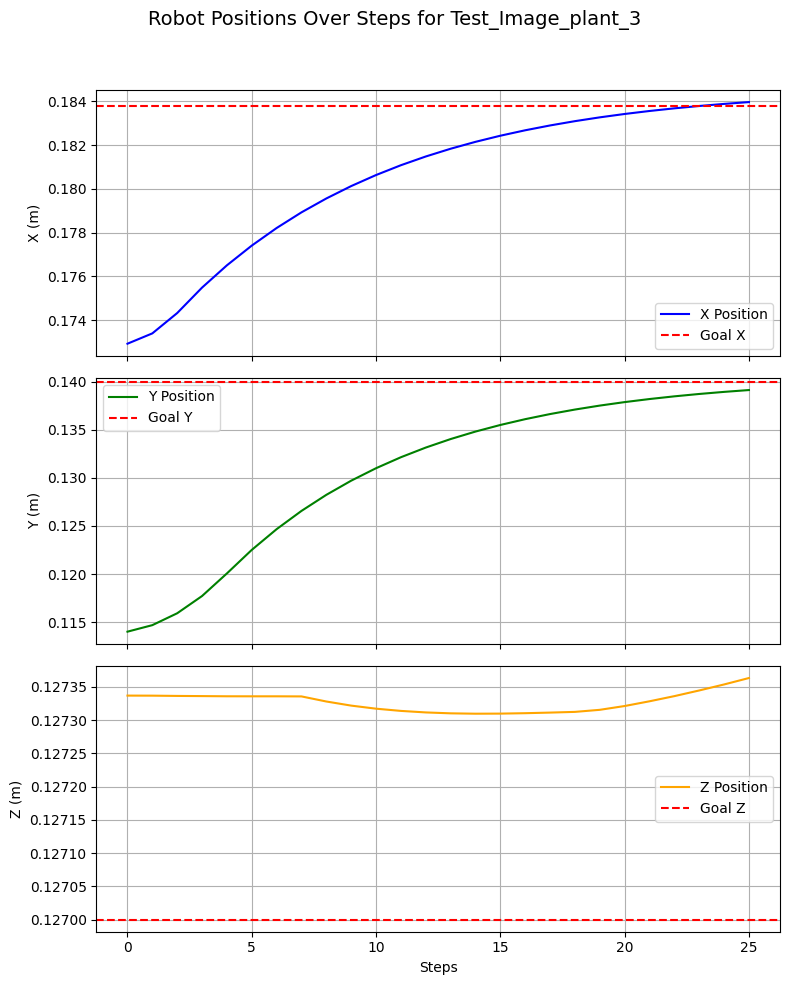

Final accuracy for Test_Image_plant_3: X=0.0002m, Y=0.0008m, Z=0.0004m


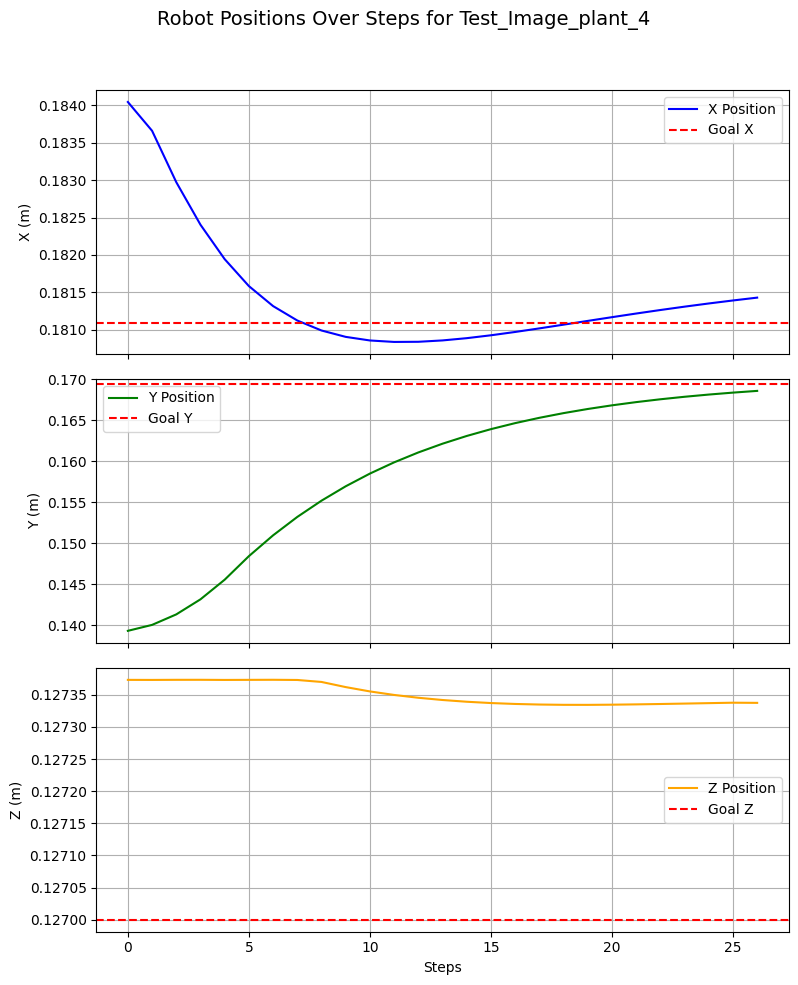

Final accuracy for Test_Image_plant_4: X=0.0003m, Y=0.0008m, Z=0.0003m


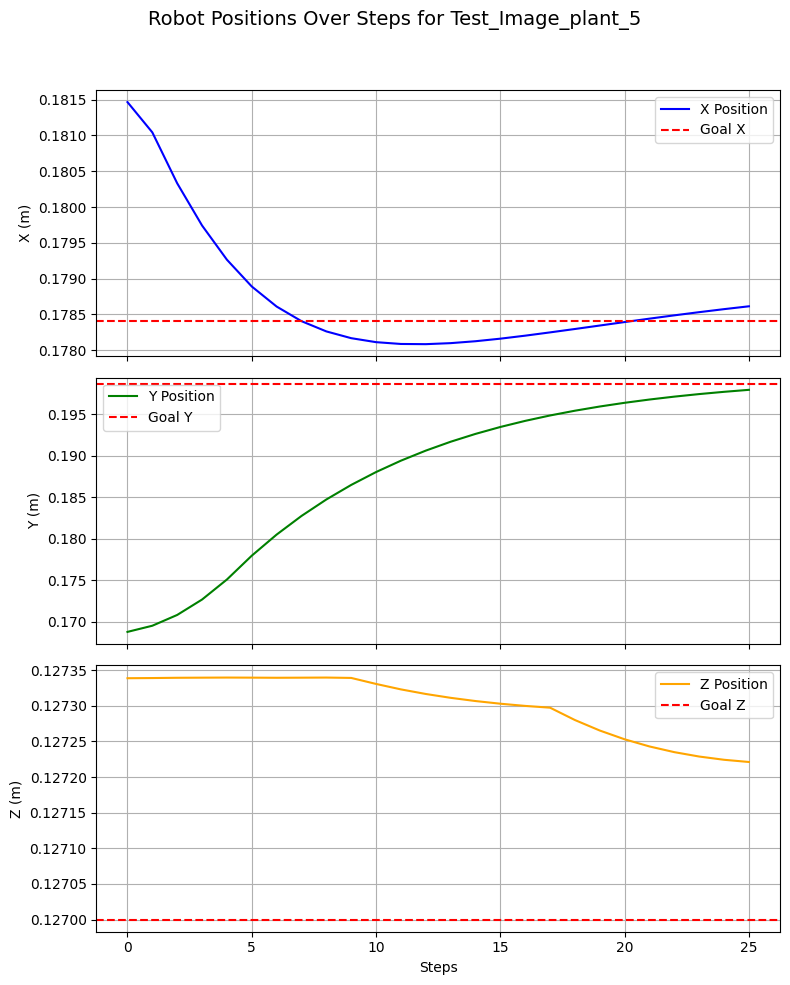

Final accuracy for Test_Image_plant_5: X=0.0002m, Y=0.0008m, Z=0.0002m


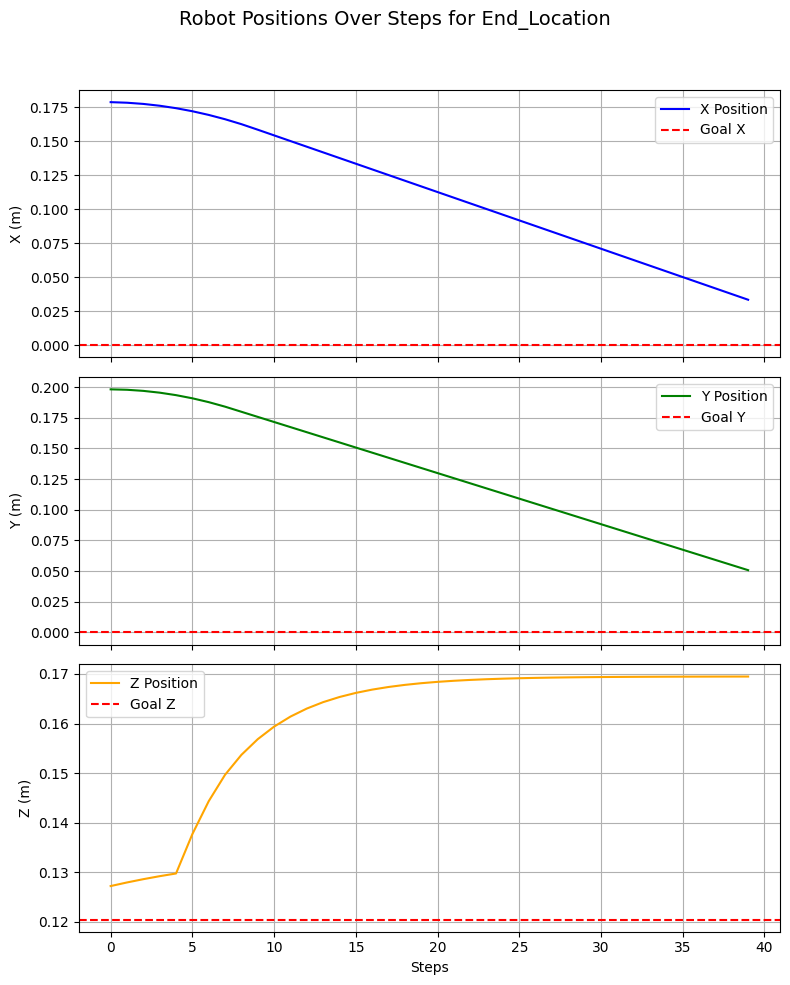

Final accuracy for End_Location: X=0.0334m, Y=0.0507m, Z=0.0490m

All plants processed. Simulation complete.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

# Load the trained PPO model
model = PPO.load("model(14)") #14

if __name__ == "__main__":
    # Ensure `root_points_robot` is defined
    try:
        root_points_robot
    except NameError:
        raise ValueError("root_points_robot is not defined. Please define it before running the script.")

    # Assume `env` is already created and assigned
    obs = env.reset()[0]  # Reset environment once to get the initial observation

    # Dictionary to store positions for plotting
    all_positions = {}

    # Get the list of plants to process
    plant_keys = list(root_points_robot.keys())

    # Iterate through all target locations
    for idx, plant in enumerate(plant_keys):
        # Set the goal position for the robot
        goal_x, goal_y, goal_z = root_points_robot[plant]
        env.goal_position = (goal_x, goal_y, goal_z)

        print(f"\nProcessing {plant} with goal coordinates: (X={goal_x}, Y={goal_y}, Z={goal_z})")

        # Storage lists for the robot's position
        x_positions, y_positions, z_positions = [], [], []
        steps = 0

        while True:
            # Predict action using the RL model
            action, _states = model.predict(obs, deterministic=True)
            
            # Step in the environment
            obs, rewards, terminated, truncated, info = env.step(action)
            steps += 1

            # Robot's current position
            robot_x, robot_y, robot_z = obs[0], obs[1], obs[2]

            # Store positions
            x_positions.append(robot_x)
            y_positions.append(robot_y)
            z_positions.append(robot_z)

            # Compute the distance to the goal
            distance = np.linalg.norm([goal_x - robot_x, goal_y - robot_y, goal_z - robot_z])

            print(f"Step {steps}:")
            print(f"    Action taken: {action}")
            print(f"    Robot position: (X={robot_x:.4f}, Y={robot_y:.4f}, Z={robot_z:.4f})")
            print(f"    Reward: {rewards:.4f}")
            print(f"    Current distance to goal: {distance:.4f}")

            # Drop inoculum if within the required error threshold (except for the last plant)
            if distance < 0.001:  # e.g. 1mm threshold
                if idx < len(plant_keys) - 1:
                    print("    Within error threshold. Dropping inoculum.")
                    drop_action = np.array([0, 0, 0, 1])  # Drop action
                    obs, rewards, terminated, truncated, info = env.step(drop_action)
                    print(f"    Dropping inoculum. Final observation: {obs}")
                else:
                    print(f"    Skipping drop action for the last location: {plant}.")
                break

            # Exit loop if the episode terminates
            if terminated or truncated:
                print("    Episode terminated or truncated unexpectedly.")
                break

        # Store the trajectory of robot positions for this plant
        all_positions[plant] = (x_positions, y_positions, z_positions)

    # Plot X, Y, Z positions for each plant in separate subplots
    for plant, (x_positions, y_positions, z_positions) in all_positions.items():
        goal_x, goal_y, goal_z = root_points_robot[plant]

        # Create subplots
        fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
        fig.suptitle(f"Robot Positions Over Steps for {plant}", fontsize=14)

        # 1) X Position
        axes[0].plot(x_positions, label='X Position', color='blue')
        axes[0].axhline(y=goal_x, color='red', linestyle='--', label='Goal X')
        axes[0].set_ylabel('X (m)')
        axes[0].legend()
        axes[0].grid(True)

        # 2) Y Position
        axes[1].plot(y_positions, label='Y Position', color='green')
        axes[1].axhline(y=goal_y, color='red', linestyle='--', label='Goal Y')
        axes[1].set_ylabel('Y (m)')
        axes[1].legend()
        axes[1].grid(True)

        # 3) Z Position
        axes[2].plot(z_positions, label='Z Position', color='orange')
        axes[2].axhline(y=goal_z, color='red', linestyle='--', label='Goal Z')
        axes[2].set_ylabel('Z (m)')
        axes[2].set_xlabel('Steps')
        axes[2].legend()
        axes[2].grid(True)

        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust subplots to fit the figure title
        plt.show()

        # Print final accuracy in each axis (difference from goal)
        if x_positions and y_positions and z_positions:
            final_x = x_positions[-1]
            final_y = y_positions[-1]
            final_z = z_positions[-1]

            final_x_accuracy = abs(goal_x - final_x)
            final_y_accuracy = abs(goal_y - final_y)
            final_z_accuracy = abs(goal_z - final_z)

            print(f"Final accuracy for {plant}: "
                  f"X={final_x_accuracy:.4f}m, "
                  f"Y={final_y_accuracy:.4f}m, "
                  f"Z={final_z_accuracy:.4f}m")
        else:
            print(f"No trajectory data available for {plant}.")

    print("\nAll plants processed. Simulation complete.")
